## Importing librairies

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime
from wikidata.client import Client

## References

[[1]](http://www.cs.cmu.edu/~ark/personas/) CMU Movie Summary Corpus webpage  
[[2]](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf) _Learning Latent Personas of Film Characters_, David Bamman, Brendan O'Connor and Noah A. Smith, ACL 2013, Sofia, Bulgaria, August 2013 

# 1. Metadata

## 1.1 Dataset importation

`movie.metadata.tsv.gz` [3.4 M]


Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase. Tab-separated. The columns are:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)


`character.metadata.tsv.gz` [14 M]

Metadata for 450,669 characters aligned to the movies above, extracted from the November 4, 2012 dump of Freebase. Tab-separated. The columns are:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

In [65]:
movies_path = "data/movie.metadata.tsv"
characters_path = "data/character.metadata.tsv"

# naming the columns with adequate names
movies_column_names = ["WikiMovieID", "FreeMovieID", "Title", "ReleaseDate", "Revenue", "Runtime", "Languages", "Countries", "Genres"]
characters_column_names = ["WikiMovieID", "FreeMovieID", "ReleaseDate", "CharName", "ActorDOB", "ActorGender", "ActorHeight", "FreeEthnicityID", "ActorName", "ActorAgeRelease", "FreeMapID", "FreeCharID", "FreeActorID"]

movies = pd.read_csv(movies_path, sep='\t', header=None, names=movies_column_names)
characters = pd.read_csv(characters_path, sep='\t', header=None, names=characters_column_names)

In [3]:
display(movies.head())

,WikiMovieID,FreeMovieID,Title,ReleaseDate,Revenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
display(characters.head())

,WikiMovieID,FreeMovieID,ReleaseDate,CharName,ActorDOB,ActorGender,ActorHeight,FreeEthnicityID,ActorName,ActorAgeRelease,FreeMapID,FreeCharID,FreeActorID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg




*   Note : `ReleaseDate`doesn't have a standard format.



## 1.2 Exploring the length of the two datasets

In [5]:
n_mov = len(movies)
n_char = len(characters)
print('Number of rows in the movie.metadata dataset :', n_mov)
print('Number of rows in the character.metadata dataset :', n_char)

Number of rows in the movie.metadata dataset : 81741
Number of rows in the character.metadata dataset : 450669


## 1.3 Cleaning Dictionaries
Columns `Languages`, `Countries`, `Genres` are tuples containing both the Freebase ID and the actual name, for each entry. We will keep only the names for the sake of clarity.

In [6]:
def extract_values(column):
  values = []
  column=json.loads(column)
  for key in column:
    values.append(column[key])
  return values

movies.Languages = movies.Languages.apply(extract_values)
movies.Countries = movies.Countries.apply(extract_values)
movies.Genres = movies.Genres.apply(extract_values)

In [7]:
display(movies[["Languages", "Countries", "Genres"]].head())

,Languages,Countries,Genres
0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,[German Language],[Germany],[Drama]


## 1.4 Checking duplicates in the movies dataset

In [8]:
for column in movies.columns:
  duplicated_rows = movies[column].duplicated().sum()
  print("{} has {} duplicated rows".format(column, duplicated_rows))

WikiMovieID has 0 duplicated rows
FreeMovieID has 0 duplicated rows
Title has 6263 duplicated rows
ReleaseDate has 61351 duplicated rows
Revenue has 74378 duplicated rows
Runtime has 81143 duplicated rows
Languages has 79924 duplicated rows
Countries has 79617 duplicated rows
Genres has 57924 duplicated rows


The fact that `Title`has a duplicated rows is a bit concerning. We see however than `WikiMovieID` and movies `FreeMovieID` have only unique entries. This can indicate us that movies can have the same title while being actually different movies. We can also check the runtimes of movies with the same name : it is very unlikely that 2 different movies having the same title woule have the exact same runtime. This reasoning can also be done for the release date.

//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////   
TODO : a code cell which outputs the movies that have the same name AND that have the same runtime ?   
TODO : a code cell which outputs the movies that have the same name AND that have the same release date ?  
and then check manually if there is an error in the runtime or the release date, using the freebase id  
and then maybe delete the following example cells? as will have been already checked

In [9]:
movies[movies.Title=="Hunting Season"]

,WikiMovieID,FreeMovieID,Title,ReleaseDate,Revenue,Runtime,Languages,Countries,Genres
62836,29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"[Turkish Language, English Language]",[Turkey],"[Crime Fiction, Mystery, Drama, Thriller]"


Wrong input for release date (1010->2010)

In [10]:
movies[movies.Title=="Harlow"]

,WikiMovieID,FreeMovieID,Title,ReleaseDate,Revenue,Runtime,Languages,Countries,Genres
623,3670013,/m/09thsq,Harlow,1965-06-23,1000000.0,109.0,[English Language],[United States of America],"[Biographical film, Biography, Drama, Black-an..."
1223,27171821,/m/0bwklv0,Harlow,1965,NaN,109.0,[],[United States of America],[Biographical film]


Actually these are 2 different movies, but the first movie `WikiID`=3670013 has a wrong runtime (the correct runtime for this ID is 125 and not 109).

So far couldn't find an example of a duplicated movie + No duplicated Wiki/Freebase IDs -> Lets trust the dataset 🙃

//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

## 1.5 Dealing with missing values

We want to see which columns have missing entries, and for those columns what is the percentage of missing entries.

In [11]:
movies.isna().any()

WikiMovieID    False
FreeMovieID    False
Title          False
ReleaseDate     True
Revenue         True
Runtime         True
Languages      False
Countries      False
Genres         False
dtype: bool

For the movies dataset, only `ReleaseDate`, `Revenue` and `Runtime` have missing entries.

In [24]:
mov_missing = movies[['ReleaseDate', 'Revenue', 'Runtime']].isna().sum()
print('Percentage of missing entries in the movie dataset (%):')
for x in range(len(mov_missing.values)):
    print(mov_missing.index[x], ':', round(100*mov_missing.values[x]/n_mov, 2))

Percentage of missing entries in the movie dataset (%):
ReleaseDate : 8.44
Revenue : 89.72
Runtime : 25.02


90% of the revenues are non specified. We won't use this feature in our project.  
8% of the release dates and 25% of the runtimes are missing, we can fill them if we find the correct ones.

In [ ]:
characters.isna().any()

WikiMovieID        False
FreeMovieID        False
ReleaseDate         True
CharName            True
ActorDOB            True
ActorGender         True
ActorHeight         True
FreeEthnicityID     True
ActorName           True
ActorAgeRelease     True
FreeMapID          False
FreeCharID          True
FreeActorID         True
dtype: bool

In [26]:
char_missing = characters[['ReleaseDate', 'CharName', 'ActorDOB', 'ActorGender', 'ActorHeight', 'FreeEthnicityID', 'ActorName',
                           'ActorAgeRelease', 'FreeCharID', 'FreeActorID']].isna().sum()
print('Percentage of missing entries in the characters dataset (%):')
for x in range(len(char_missing.values)):
    print(char_missing.index[x], ':', round(100*char_missing.values[x]/n_char, 2))

Percentage of missing entries in the characters dataset (%):
ReleaseDate : 2.22
CharName : 57.22
ActorDOB : 23.55
ActorGender : 10.12
ActorHeight : 65.65
FreeEthnicityID : 76.47
ActorName : 0.27
ActorAgeRelease : 35.08
FreeCharID : 57.22
FreeActorID : 0.18


### Recovering Ethnicities names corresponding to their Freebase ID

`Ethnicity` only has the ID of the Freebase database whose API is currently depreciated. To solve this problem we use the [Freebase/Wikidata Mappings](https://developers.google.com/freebase#freebase-wikidata-mappings) which as the name suggests maps the given Freebase Ids to WikiData.

- Note : The data has been created based on the Wikidata-Dump of October 28, 2013, and contains only those links that have at least two common Wikipedia-Links and not a single disagreeing Wikipedia-Link. Since the movies/characters dataset were gathered during that time too there is no time conflict.

In [66]:
mappings_path = "data/fb2w.nt.gz"
maps = pd.read_csv(mappings_path, sep='\t', header=None, skiprows=4, names=["Freebase", "W3", "Wiki"])
display(maps.head())

,Freebase,W3,Wiki
0,<http://rdf.freebase.com/ns/m.0695j>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q6718> .
1,<http://rdf.freebase.com/ns/m.05nrg>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q538> .
2,<http://rdf.freebase.com/ns/m.0jgd>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q414> .
3,<http://rdf.freebase.com/ns/m.0d_23>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q2537> .
4,<http://rdf.freebase.com/ns/m.04g7d>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q315> .


We only need the ID and not the whole website link so we transform columns in the following way :
- Freebase : <http://rdf.freebase.com/ns/m.CODE_ID> -> /m/CODE_ID
- Wiki : <http://www.wikidata.org/entity/CODE_ID> -> CODE_ID

In [67]:
"""
Transforms the Freebase website to Freebase ID
"""
def elim_freebase(web):
    return "/m/"+web[30:-1]

"""
Transforms the Freebase website to Freebase ID
"""
def elim_wiki(web):
    return web[32:-3]

In [68]:
maps["free"] = maps.Freebase.apply(elim_freebase)
maps["wiki"] = maps.Wiki.apply(elim_wiki)

# We don't need the rest of the columns so we drop them 
maps.drop(columns = ["Freebase", "W3", "Wiki"], inplace=True)
maps.head()

,free,wiki
0,/m/0695j,Q6718
1,/m/05nrg,Q538
2,/m/0jgd,Q414
3,/m/0d_23,Q2537
4,/m/04g7d,Q315


Firstly, we get the Wikidata IDs based on the mapping we created :

In [69]:
characters = characters.merge(maps, how="left", left_on="FreeEthnicityID", right_on="free")
characters.drop(columns=["free"], inplace=True)
characters.rename(columns={"wiki":"Ethnicity_W"}, inplace=True)
display(characters.head())

,WikiMovieID,FreeMovieID,ReleaseDate,CharName,ActorDOB,ActorGender,ActorHeight,FreeEthnicityID,ActorName,ActorAgeRelease,FreeMapID,FreeCharID,FreeActorID,Ethnicity_W
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,Q49085
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450727,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,NaN
450728,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,NaN
450729,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,Q42406
450730,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,NaN


As we can see the mapping is not complete : Some Freebase IDs do not correspond to any Wikidata ID. 

In [71]:
unmapped_ethnicities = characters.Ethnicity_W.isna().sum() - characters.FreeEthnicityID.isna().sum()
print("There are {} instances of ethnicities that we could not map from Freebase to Wikidata".format(unmapped_ethnicities))
# Instances of ethnicities -> Can we replace by number of actors ethnicities? Actors with different initial ethnicities ?

There are 12992 instances of ethnicities that we could not map from Freebase to Wikidata


In [72]:
"""
Given a Wikidata ID (eg. "Q49085") returns the corresponding label 

Using this function row by row (pd.apply method) takes enormous time -> improvement? For ethnicities its ok as they're only 350 dinstinct ones
"""
def get_wikidata_label(wikidata_id):
    client = Client()
    entity = client.get(wikidata_id, load=True)
    return str(entity.label)

In [73]:
# Result is map_Ethnicity_W_to_Ethnicity_name a map between Ethnicity wikidata ID and Ethnicity label
map_Ethnicity_W_to_Ethnicity_name = pd.DataFrame(characters.Ethnicity_W.unique(), columns=["Ethnicity_W"]).dropna()
map_Ethnicity_W_to_Ethnicity_name["EthnicityName"] = map_Ethnicity_W_to_Ethnicity_name.Ethnicity_W.apply(get_wikidata_label)

In [74]:
characters = characters.merge(map_Ethnicity_W_to_Ethnicity_name, how="left", left_on="Ethnicity_W", right_on="Ethnicity_W").drop(columns= ["FreeEthnicityID", "Ethnicity_W"])
display(characters.head())

,WikiMovieID,FreeMovieID,ReleaseDate,CharName,ActorDOB,ActorGender,ActorHeight,ActorName,ActorAgeRelease,FreeMapID,FreeCharID,FreeActorID,EthnicityName
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN


In [75]:
ethn_len = len(characters.EthnicityName.value_counts())
ethn_len

355

The whole ethnicities plot (355 different ethnicities) was not really readable, so :
- what are the most present ones (ex 20 first) 
- group some ethnicities together into big categories

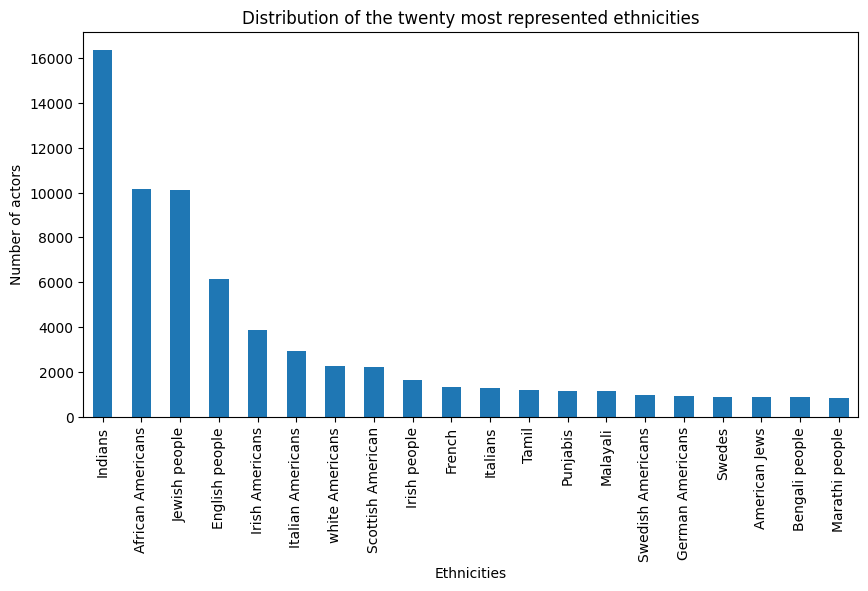

In [46]:
# Ethnicities visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
characters.EthnicityName.value_counts()[:20].plot(kind="bar")
plt.xlabel('Ethnicities')
plt.ylabel('Number of actors')
plt.title('Distribution of the twenty most represented ethnicities');

### I don't know on what I should base the big ethnicity categories : maybe
- American Indian or Alaska Native
- Asian
- Black or African American
- Hispanic or Latino
- Native Hawaiian or Other Pacific Islander
- White

In [55]:
print('The percentage of missing Ethnicity names is :', round(100*characters[['EthnicityName']].isna().sum().values[0]/n_char,2), '%')

The percentage of missing Ethnicity names is : 79.35 %


We only have the names of 20% of the actor ethnicities : this is not enough to base our analysis and to draw conclusions. We thus decided to not use the Ethnicity in our project.

### Recovering missing Actor names corresponding to their Freebase ID when specified

In addition, some actors do not have their name and/or date of birth and/or sex specified but the actor freebase ID is present. We can use the actor freebase ID to recover their Wikidata information. This gives us access to the following relevant information about the actor :
- Name
- Sex/Gender
- Date of Birth  
We can therefore replace the missing values in those categories, when the Actor Freebase ID is specified.

In [59]:
print('Number of rows where:\n\tActor is missing but actor ID is specified :', len(characters[(characters['ActorName'].isna() & ~characters['FreeActorID'].isna())]))
print('\tActor and DOB are missing but actor ID is specified :', len(characters[(characters['ActorName'].isna() & characters['ActorDOB'].isna() & ~characters['FreeActorID'].isna())]))
print('\tActor and Gender are missing but actor ID is specified :', len(characters[(characters['ActorName'].isna() & characters['ActorGender'].isna() & ~characters['FreeActorID'].isna())]))
print('\tActor, DOB and Gender are missing but actor ID is specified :', len(characters[(characters['ActorName'].isna() & characters['ActorDOB'].isna() & characters['ActorGender'].isna() & ~characters['FreeActorID'].isna())]))
print('\tDOB is missing but Actor and actor ID are specified :', len(characters[(~characters['ActorName'].isna() & characters['ActorDOB'].isna() & ~characters['FreeActorID'].isna())]))
print('\tGender is missing but Actor and actor ID are specified :', len(characters[(~characters['ActorName'].isna() & characters['ActorGender'].isna() & ~characters['FreeActorID'].isna())]))
print('\tDOB and Gender are missing but Actor and actor ID are specified :', len(characters[(~characters['ActorName'].isna() & characters['ActorDOB'].isna() & characters['ActorGender'] & ~characters['FreeActorID'].isna())]))

Number of rows where:
	Actor is missing but actor ID is specified : 413
	Actor and DOB are missing but actor ID is specified : 400
	Actor and Gender are missing but actor ID is specified : 401
	Actor, DOB and Gender are missing but actor ID is specified : 400
	DOB is missing but Actor and actor ID are specified : 104930
	Gender is missing but Actor and actor ID are specified : 44393
	DOB and Gender are missing but Actor and actor ID are specified : 62635


### Starting with recovery of missing Actor names
For this, we perform the same as in the Ethnicity names recovery.

In [76]:
characters = characters.merge(maps, how="left", left_on="FreeActorID", right_on="free")
characters.drop(columns=["FreeActorID"], inplace=True)
characters.rename(columns={"wiki":"WikiActorID"}, inplace=True)
display(characters.head())

,WikiMovieID,FreeMovieID,ReleaseDate,CharName,ActorDOB,ActorGender,ActorHeight,ActorName,ActorAgeRelease,FreeMapID,FreeCharID,EthnicityName,free,WikiActorID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,NaN,/m/03wcfv7,Q1873468
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,NaN,/m/0346l4,Q230527
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,African Americans,/m/01vw26l,Q173637
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,NaN,/m/034hyc,Q169963
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,NaN,/m/01y9xg,Q233347


In [77]:
missing_actor = characters[(characters['ActorName'].isna() & ~characters['WikiActorID'].isna())]

In [78]:
map_WikiActorId_Actor = pd.DataFrame(missing_actor.WikiActorID.unique(), columns=["WikiActorID"]).dropna()
map_WikiActorId_Actor["ActorName"] = map_WikiActorId_Actor.WikiActorID.apply(get_wikidata_label)

In [79]:
characters = characters.merge(map_WikiActorId_Actor, how="left", left_on="WikiActorID", right_on="WikiActorID").drop(columns= ["WikiActorID", "WikiActorID"])
characters.drop(columns="free", inplace=True)

In [80]:
characters["ActorName"] = characters.fillna(value={"ActorName_x":""}).ActorName_x + characters.fillna(value={"ActorName_y":""}).ActorName_y
characters.drop(columns=["ActorName_x", "ActorName_y"], inplace=True)

In [81]:
characters.head()

,WikiMovieID,FreeMovieID,ReleaseDate,CharName,ActorDOB,ActorGender,ActorHeight,ActorAgeRelease,FreeMapID,FreeCharID,EthnicityName,ActorName
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,42.0,/m/0bgchxw,/m/0bgcj3x,NaN,Wanda De Jesus
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,27.0,/m/0jys3m,/m/0bgchn4,NaN,Natasha Henstridge
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,32.0,/m/0jys3g,/m/0bgchn_,African Americans,Ice Cube
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,33.0,/m/02vchl6,/m/0bgchnq,NaN,Jason Statham
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,23.0,/m/02vbb3r,/m/0bgchp9,NaN,Clea DuVall


From wikidata actor page,
- sex/gender (P21) is given as : male (Q6581097), female (Q6581072), intersex (Q1097630), transgender female (Q1052281), transgender male (Q2449503).
- date of birth (P569) is given as : Day of the month as a zero-padded decimal number, blank space, Month full name, blank space, Year with century as a decimal number. To recover the date of birth in the same format as the ones in the characters dataset, we must read the date given by wikidata without the blank spaces and then use datetime to format it correctly. See example just below :

In [33]:
from datetime import datetime
wiki_date = '26 December 1949'
no_space = wiki_date.replace(" ", "")
date = datetime.strptime(no_space, '%d''%B''%Y')
formated_date = '{:%Y-%m-%d}'.format(date)
print(formated_date)

1949-12-26


We later decided that we won't use the actors information, so we didn't push further and didn't recover missing DOB or genders.

# 2. Plot summaries and metascores

## 2.1 Plot summaries integration to Movies dataset

## 2.2 Missing plot summaries check

## 2.3 Preprocessing
- convert into lists
- lowercase

## 2.4 Extract metascores from https://github.com/miazhx/metacritic (instead of iMBd)

## 2.5 First analyses and visualization

### General
number of sentences, number of words, number of punctuation, 10 most used words (global), 10 most used words (without ‘and’, ‘for’ …)  
maybe add those as ‘features’ of the dataset : for example a lot of ‘!’ and ‘?’ may give hints about anxiety  
histograms and other plots  
mean, median, std  

### Specific to our project : sentiment and concerns
number of positive/negative words

https://huggingface.co/siebert/sentiment-roberta-large-english?text=I+like+you.+I+love+you

https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc

https://github.com/Ejhfast/empath-client 

### Look for changes in distribution over time and over geographical regions